# PR201 PROJECT: Model for stress level prediction

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Load Data
df = pd.read_csv("/kaggle/input/plant-data/plant_data.csv")  
df.head()


,Timestamp,Plant_ID,Soil_Moisture,Ambient_Temperature,Soil_Temperature,Humidity,Light_Intensity,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Chlorophyll_Content,Electrochemical_Signal,Plant_Health_Status
0,2024-10-03 10:54:53.407995,1,27.654953,22.481220,21.712729,55.036722,583.390279,5.657356,10.272198,45.076938,37.543038,35.713189,1.025817,High Stress
1,2024-10-03 16:54:53.407995,1,15.320620,21.411837,18.822274,64.036244,584.568599,7.111167,32.086144,27.425913,19.260635,28.662319,0.109262,High Stress
2,2024-10-03 22:54:53.407995,1,17.548431,21.853669,15.584587,67.207948,581.119809,5.737248,26.859348,29.231939,36.050896,43.599841,1.083925,High Stress
3,2024-10-04 04:54:53.407995,1,16.176333,22.140772,22.617952,58.321804,225.230390,5.577162,17.323364,28.064518,26.070144,39.096097,1.211003,High Stress
4,2024-10-04 10:54:53.407995,1,39.105541,29.262461,18.026322,64.641771,457.262395,5.876076,10.103143,37.140469,38.028482,47.144232,1.545441,High Stress


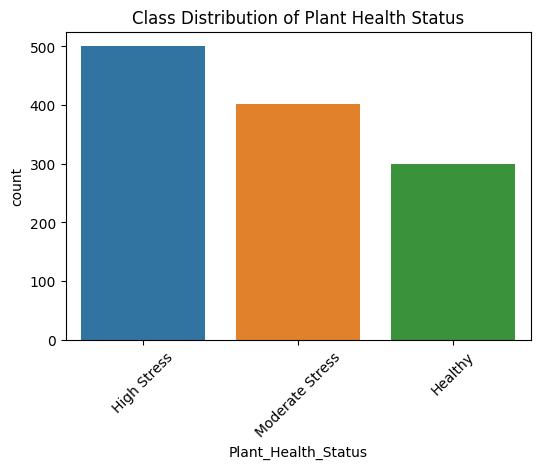

In [2]:
# Exploratory Data Analysis
df = df.drop(columns=["Timestamp", "Plant_ID"])

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Plant_Health_Status")
plt.title("Class Distribution of Plant Health Status")
plt.xticks(rotation=45)
plt.show()


In [3]:
# Data Preprocessing
# Encode target variable
le = LabelEncoder()
df["Plant_Health_Status"] = le.fit_transform(df["Plant_Health_Status"])

X = df.drop(columns=["Plant_Health_Status"])
y = df["Plant_Health_Status"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
# Model Training - Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


Accuracy: 0.9458333333333333
F1 Score (Weighted): 0.9457950788907655

 Classification Report:
                 precision    recall  f1-score   support

        Healthy       0.97      0.95      0.96        65
    High Stress       0.94      0.96      0.95        85
Moderate Stress       0.93      0.92      0.93        90

       accuracy                           0.95       240
      macro avg       0.95      0.95      0.95       240
   weighted avg       0.95      0.95      0.95       240



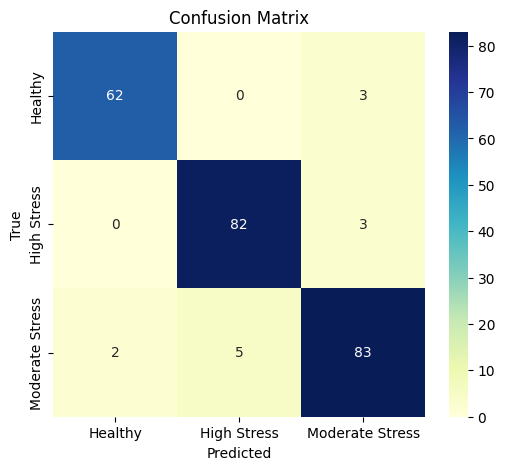

In [5]:
# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (Weighted):", f1_score(y_test, y_pred, average="weighted"))

print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Conclusion: The Random Forest model performs well at identifying plant stress levels.**


In [7]:
!pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 8.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 6.31.1 which is incompatible.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 6.31.1 which is incompatible.
pandas-gbq 0.29.

In [8]:
# Convert to ONNX
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Set input shape: 11 features
initial_type = [("float_input", FloatTensorType([None, X_train.shape[1]]))]

# Ensure outputs are tensors by disabling zipmap
onnx_model = convert_sklearn(
    rf,
    initial_types=initial_type,
    options={id(rf): {"zipmap": False}}
)

# Save ONNX model
with open("plant_stress_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print(" ONNX model saved successfully as 'plant_stress_model.onnx'")


 ONNX model saved successfully as 'plant_stress_model.onnx'
